# Wind Farm Test

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import time
import os
from IPython.display import display, clear_output
from scipy import optimize
from itertools import product

# Import custom libraries
# from import_model import Model
import functions as func
import visualization as viz

# Test libraries
# from import_model import CCM

In [2]:
# Import models
from floris.tools import FlorisInterface as floris

# Add names of newly added models in this list
model_names = [
    'CCM',
]

ref_models = [
    'LES',
]

# Functions
def get_fitted_ABL(
    df_ref_flowfield: pd.DataFrame,
    ref_model: str,
    z_ref_guess: float = 100.,
    U_ref_guess: float = 10.,
    alpha_guess: float = 0.12,
):
    if ref_model not in ref_models:
        raise ValueError('"ref_model" is not in list of valid reference models')
    
    # # Add new reference model types here
    # if ref_model == 'LES':
    #     ref_model == LES()
    
    # # Get streamwise and spanwise velocity profile parameters
    # U_params, V_params = get_U_and_V_params(df_ref_flowfield)

    # # Get farm initialized with flow field equal to LES simulation
    # farm = get_farm_with_fitted_flow_field(
    #     U_params,
    #     V_params,
    # )



# Create classes for models
class LES:
    def __init__(
        self,
    ):
        pass




class CCM:
    '''
    If you want to update changes made in FLORIS, first move towards
    the right folder in the terminal with right environment by (for example):
    cd Documents\Technische Universiteit Eindhoven\Graduation Project
    And afterwards reinstall FLORIS as follows:
    pip install -e floris_tilt
    '''
    def __init__(
        self,
        model_params: dict = None,
        input_file: str = 'model_files/CCM/case_initial.yaml',
    ):
        self.input_file = input_file
        self.model_params = model_params

        self.farm = floris(self.input_file)
        
    def get_farm(self):
        return self.farm
    
    def set_model_params(
        self,
        model_params: dict,
    ):
        for key in model_params.keys():
            found = False

            if key in self.farm.floris.wake.wake_deflection_parameters['gaussm'].keys():
                self.farm.floris.wake.wake_deflection_parameters['gaussm'][key] = model_params[key]
                found = True

            if key in self.farm.floris.wake.wake_velocity_parameters['ccm'].keys():
                self.farm.floris.wake.wake_velocity_parameters['ccm'][key] = model_params[key]
                found = True
            
            if not found:
                print(f'Key named "{key}" not found in either model')
    
    def reinitialize_farm(
        self,
        farm_config: dict,
        model_params: dict = None,
    ):
        if model_params == None:
            model_params = self.model_params
        
        for _ in range(2):
            self.farm.reinitialize(
                layout_x=farm_config['X'].flatten(), 
                layout_y=farm_config['Y'].flatten(), 
                wind_directions=farm_config['wind_directions'],
                wind_speeds=farm_config['wind_speeds'],
            )

            if model_params is not None:
                self.set_model_params(model_params)

    def get_turbine_powers(
        self,
        farm_config: dict,
    ):  
        # Get yaw and tilt angles flattened and adjust for number of wind conditions
        yaw_angles = farm_config['yaw_angles'].flatten()[None, None]
        tilt_angles = farm_config['tilt_angles'].flatten()[None, None]

        farm_copy = self.farm.copy()

        # Calculate wakes
        farm_copy.calculate_wake(
            yaw_angles=yaw_angles,
            tilt_angles=tilt_angles,
        )

        # Get misalignment correction factors
        correction_factors = func.get_correction_factor_misalignment(
            yaw_angles,
            tilt_angles,
        )

        # Get total power (need to account for air density and correction factor)
        turbine_powers = farm_copy.get_turbine_powers() * \
            farm_copy.floris.flow_field.air_density * \
            correction_factors

        return turbine_powers

    def get_velocity_field(
        self,
        farm_config,
        coordinates,
    ):
        farm_copy = self.farm.copy()

        _, flowfield, _ = farm_copy.calculate_full_domain(
            x_bounds=coordinates['X'],
            y_bounds=coordinates['Y'],
            z_bounds=coordinates['Z'],
            yaw_angles=farm_config['yaw_angles'].flatten()[None, None],
            tilt_angles=farm_config['tilt_angles'].flatten()[None, None],
        )

        # Save velocities in velocity field
        velocity_field = {
            'U': flowfield.u_sorted[0, 0],
            'V': flowfield.v_sorted[0, 0],
            'W': flowfield.w_sorted[0, 0],
        }

        return velocity_field


# Create class to get model
class WakeModeling:
    def __init__(
        self,
        model_name: str,
        model_params: dict = None,
    ): 
        if model_name not in model_names:
            raise ValueError('"model_name" is not in list of valid model names')
        
        self.model_name = model_name
        self.model_params = model_params
        self.X = np.array([0])
        self.Y = np.array([0])

        self.set_model()

    def set_model(self):
        # Add new models right here
        if self.model_name == 'CCM':
            self.model = CCM(self.model_params)
            self.farm = self.model.get_farm()

    def get_farm(self):
        return self.farm
    
    def get_model_class(self):
        return self.model_class
    
    def set_farm_layout(
        self,
        D_rotor: float = 126,
        n_x: int = 1,
        n_y: int = 1,
        spacing_x: float = 5,
        spacing_y: float = 5,
        hexagonal: bool = False,
        spacing_hex: float = 5,
    ):
        self.X, self.Y = func.create_farm_layout(
            D_rotor=D_rotor, 
            n_x=n_x, 
            n_y=n_y, 
            spacing_x=spacing_x, 
            spacing_y=spacing_y, 
            hexagonal=hexagonal,
            spacing_hex=5, 
        )

    def set_farm_layout_custom(
        self,
        X,
        Y,
    ):
        self.X = X
        self.Y = Y
    
    def get_farm_layout(self):
        return self.X, self.Y

    def run_model(
        self,
        farm_config,
    ):
        self.model.reinitialize_farm(
            farm_config,
        )

        turbine_powers = self.model.get_turbine_powers(
            farm_config,
        )

        return turbine_powers

    def get_velocity_field(
        self,
        farm_config,
        coordinates,
    ):
        self.model.reinitialize_farm(
            farm_config,
        )

        velocity_field = self.model.get_velocity_field(
            farm_config,
            coordinates,
        )

        return velocity_field        

### Load cases
Here, the csv file is read, which contains data about farm configurations.

In [16]:
# Specify location of csv and file name of csv
location_case_file = '../TouchWind_Optimization_Framework/'
case_file_name = 'test_cases.csv'

# Read case file
df_loaded_cases = pd.read_csv(location_case_file + case_file_name)

# Get list of case names
mask_test = (df_loaded_cases['test'] == 1)
loaded_case_names = df_loaded_cases['case_name'][mask_test].reset_index(drop=True)

# Get number of cases
n_loaded_cases = len(loaded_case_names)

# Show begin of case file
df_loaded_cases.head()

,case_name,test,calibration_power_output,calibration_plane,optimization,stratisfaction_level,z_ref,U_ref,wd,wd_eff,...,yaw_0,tilt_0,x_1,y_1,yaw_1,tilt_1,x_2,y_2,yaw_2,tilt_2
0,1x1TURB_wd270_ws10_1x_y0_t5,1,NaN,NaN,1,neutral,100,10,270,0,...,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2x1TURB_wd270_ws10_2x_y0_t5,1,NaN,NaN,1,neutral,100,10,270,0,...,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3x1TURB_wd270_ws10_3x_y0_t5,1,NaN,NaN,1,neutral,100,10,270,0,...,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4x1TURB_wd270_ws10_4x_y0_t5,1,NaN,NaN,1,neutral,100,10,270,0,...,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2x2TURB_wd270_ws10_4x_y0_t5,1,NaN,NaN,1,neutral,100,10,270,0,...,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Specify location of reference data
location_ref_data = '../LES/'

# Get flowfield of LES to fit ABL
ref_case_name = '1TURB_wd270_ws10_1x_y0_t5'
ref_flowfield = pd.read_csv(location_ref_data + ref_case_name + '/' + ref_case_name + '.csv')

In [5]:
# Initialize dictionary of farm configurations
loaded_farm_configs = {}

# Create farm configurations
for idc, case_name in enumerate(loaded_case_names):
    loaded_farm_configs[case_name] = func.create_farm_config(
        df_loaded_cases[df_loaded_cases['case_name'] == case_name].iloc[0]
    )

### Create custom cases
Here, custom cases can be created.

In [6]:
custom_farm_configs = {}

In [8]:
new_custom_case_name = 'test'

n_x = 3
n_y = 3

X, Y = func.create_farm_layout(
    D_rotor=126,
    n_x=n_x,
    n_y=n_y,
    spacing_x=5,
    spacing_y=5,
    hexagonal=False,
    spacing_hex=5,
)

yaw_angles, tilt_angles = func.create_uniform_angles(
    yaw=0,
    tilt=5,
    n_x=n_x,
    n_y=n_y,
)

new_custom_case = {
    'wind_directions': [270, 280],
    'wind_speeds': [10, 12],
    'X': X,
    'Y': Y,
    'yaw_angles': yaw_angles,
    'tilt_angles': tilt_angles,
    'D_rotor': 126,
    'n_x': n_x,
    'n_y': n_y,
    'n_turbines': n_x * n_y
}

custom_farm_configs[new_custom_case_name] = new_custom_case

### Set wake modeling framework
Here, the model is specified, after which an instance of the wake modeling class is made.

In [9]:
# Set model name
model_name = 'CCM'

# Set model parameters
model_params = {
    'ad': 0,
    'bd': -0.0018192983887298023,
    'cd': 1.0803331806986867,
    'dd': -0.09040629347972164,
    'alpha': 0.58,
    'beta': 0.077,
    'dm': 1.0,
    'c_s1': 0.0563691592,
    'c_s2': 0.1376631233159683,
    'a_s': 0.3253111149080571,
    'b_s': 0.012031554853652504,
    'a_f': 3.11,
    'b_f': -0.68,
    'c_f': 2.223295807654856,
    'wr_gain': 0.5392489436318193,
    'ma_gain': 1.7431079762733077,
    'wr_decay_gain': 3.207532818500954,
    'ma_decay_gain': 1.7832719494462048,
}

# Get wakemodeling framework
wakemodeling = WakeModeling(
    model_name,
    model_params,
)

In [10]:
farm_configs = custom_farm_configs

case_names = list(farm_configs.keys())

turbine_powers = wakemodeling.run_model(
    farm_configs[case_names[0]],
)

turbine_powers

array([[[3958511.52977245, 1396463.45049005, 1304507.0665219 ,
         3958511.52977245, 1396463.45049005, 1305103.88840615,
         3958511.52977245, 1396463.45049005, 1304453.39659901],
        [6001257.47346087, 3094697.27768078, 2245786.40890997,
         6001257.47346087, 3094697.27768078, 2246367.76548213,
         6001257.47346087, 3094697.27768078, 2245575.84832332]],

       [[3958511.52977245, 3539690.21491859, 3563759.88373699,
         3958511.52977245, 3549291.92195439, 3566914.00669815,
         3958511.52977245, 3548241.14511431, 3558487.65462414],
        [6001257.47346087, 6001254.08396676, 6001253.41301169,
         6001257.47346087, 6001254.14934883, 6001253.44752105,
         6001257.47346087, 6001254.14296474, 6001253.38426671]]])

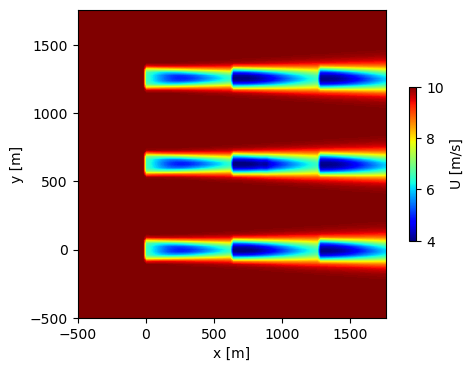

In [12]:
farm_config = farm_configs[case_names[0]]

viz.plot_velocity_field(
    wakemodeling=wakemodeling,
    farm_config=farm_config,
    component='U',
    plane='Z',
    distance=90.,
)